In [2]:
! pip install matplotlib
! pip install seaborn
! pip install dask-ml
! pip install tables

     |████████████████████████████████| 10.3 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 69.7 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 143 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.3 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 473 kB 74.5 MB/s eta 0:00:01


In [3]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
import pickle
import seaborn as sns
sns.set()
from dask_ml.preprocessing import StandardScaler
from dask_ml.decomposition import PCA
from itertools import combinations
import dask.dataframe as dd
import yaml
import os

In [4]:
config = yaml.load(open("./config.yml", "r"))

/tmp/ipykernel_577/154205166.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(open("./config.yml", "r"))


In [5]:
reqd_cols = ['Vehicle Expiration Date',
             'Violation Precinct',
             'Issuer Precinct',
             'Vehicle Year']

In [6]:
config

{'Dataset': {'2013-14': 'f"/mnt/data/{os.environ[\'DOMINO_PROJECT_NAME\']}/Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv"',
  '2015': 'f"/mnt/data/{os.environ[\'DOMINO_PROJECT_NAME\']}/Parking_Violations_Issued_-_Fiscal_Year_2015.csv"',
  '2016': 'f"/mnt/data/{os.environ[\'DOMINO_PROJECT_NAME\']}/Parking_Violations_Issued_-_Fiscal_Year_2016.csv"',
  '2017': 'f"/mnt/data/{os.environ[\'DOMINO_PROJECT_NAME\']}/Parking_Violations_Issued_-_Fiscal_Year_2017.csv"'},
 'h5': {'2013-14': 'f"/mnt/data/{os.environ[\'DOMINO_PROJECT_NAME\']}/h5/clean_data_13_14.h5"',
  '2015': 'f"/mnt/data/{os.environ[\'DOMINO_PROJECT_NAME\']}/h5/clean_data_15.h5"',
  '2016': 'f"/mnt/data/{os.environ[\'DOMINO_PROJECT_NAME\']}/h5/clean_data_16.h5"',
  '2017': 'f"/mnt/data/{os.environ[\'DOMINO_PROJECT_NAME\']}/h5/clean_data_17.h5"'},
 'PCA': {'n_components': 3},
 'KMeans': {'n_clusters': 3, 'init': 'k-means++', 'random_state': 42},
 'artifacts': {'path': './artifacts'}}

In [7]:
clean_data_15 = pd.read_hdf(eval(config['h5']['2015']))

In [8]:
clean_data_15 = dd.from_pandas(clean_data_15,chunksize=3)

In [9]:
clean_data_15

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
npartitions=3936411,,,,
0,int64,int64,int64,float64
3,...,...,...,...
...,...,...,...,...
11809230,...,...,...,...
11809232,...,...,...,...


### Dropping null values

In [10]:
clean_data_15 = clean_data_15.dropna()

In [10]:
clean_data_15.isnull().sum()

Dask Series Structure:
npartitions=1
Issuer Precinct       int64
Violation Precinct      ...
dtype: int64
Dask Name: dataframe-sum-agg, 15745645 tasks

# Type casting columns

In [7]:
clean_data_15.dtypes

Vehicle Expiration Date      int64
Violation Precinct           int64
Issuer Precinct              int64
Vehicle Year               float64
dtype: object

In [11]:
convert_dict = {'Vehicle Expiration Date': int, 
                'Violation Precinct': int,
                'Issuer Precinct' : int,
                'Vehicle Year' : int
               }
clean_data_15 = clean_data_15.astype(convert_dict).compute() 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_577/1756207307.py", line 6, in <module>
    clean_data_15 = clean_data_15.astype(convert_dict).compute()
  File "/opt/conda/lib/python3.8/site-packages/dask/base.py", line 285, in compute
    (result,) = compute(self, traverse=False, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/dask/base.py", line 567, in compute
    results = schedule(dsk, keys, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/dask/threaded.py", line 79, in get
    results = get_async(
  File "/opt/conda/lib/python3.8/site-packages/dask/local.py", line 503, in get_async
    for key, res_info, failed in queue_get(queue).result():
  File "/opt/conda/lib/python3.8/site-packages/dask/local.py", line 134, in queue_get
    return q.get()
  File "/opt/conda/lib/python3.8/queue.py", l

TypeError: object of type 'NoneType' has no len()

In [8]:
# clean_data_15.dtypes

Vehicle Expiration Date    int64
Violation Precinct         int64
Issuer Precinct            int64
Vehicle Year               int64
dtype: object

In [8]:
# clean_data_15

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year
0,11,7,7,2005
1,454,25,25,0
2,145,72,72,2010
3,11,102,102,2015
4,454,28,28,0
...,...,...,...,...
11809228,331,81,81,0
11809229,191,14,14,2013
11809230,304,18,18,2007
11809231,304,104,104,1995


# Visualizing raw data

In [12]:
# def visualize_cols(df):
#     # combination of numbers i.e. 4C2 to see how each column varies w.r.t to the other
#     comb_list = list(combinations([0,1,2,3],2))
    
#     for comb in comb_list:
#         print(reqd_cols[comb[0]])
#         print(reqd_cols[comb[1]])
        
#         plt.figure(figsize=(12,9))

#         plt.scatter(df.iloc[:,comb[0]],df.iloc[:,comb[1]])
#         plt.xlabel(reqd_cols[comb[0]])
#         plt.ylabel(reqd_cols[comb[1]])

Vehicle Expiration Date
Violation Precinct
Vehicle Expiration Date
Issuer Precinct
Vehicle Expiration Date
Vehicle Year
Violation Precinct
Issuer Precinct
Violation Precinct
Vehicle Year
Issuer Precinct
Vehicle Year


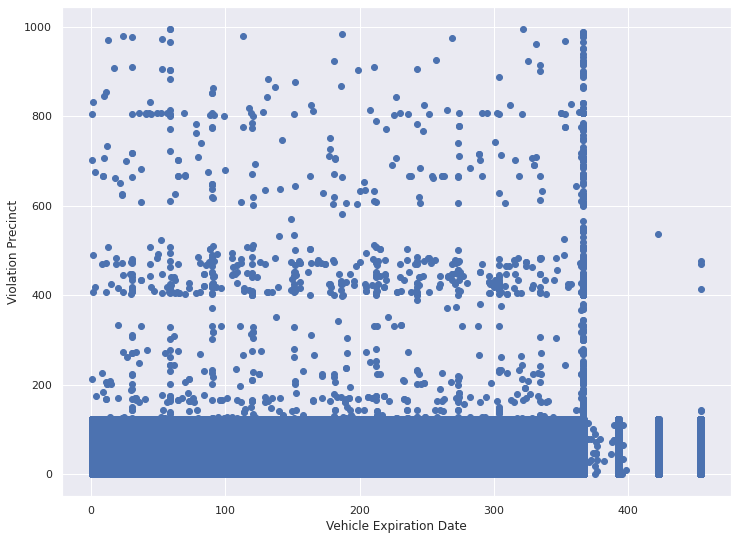

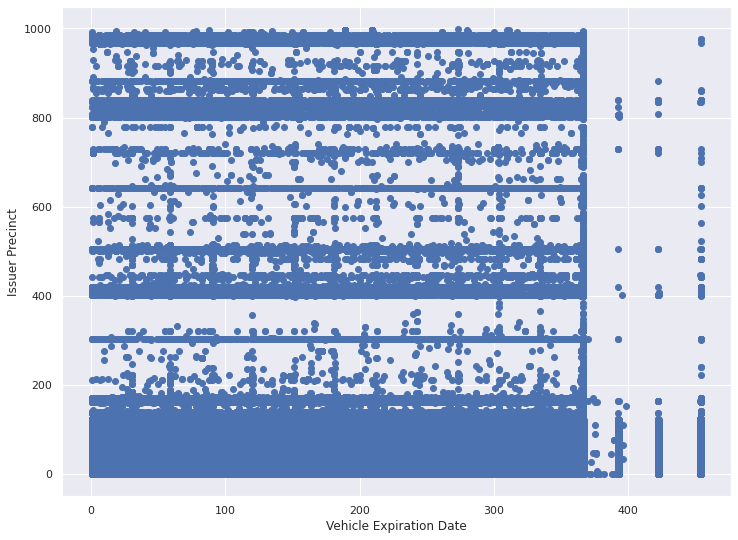

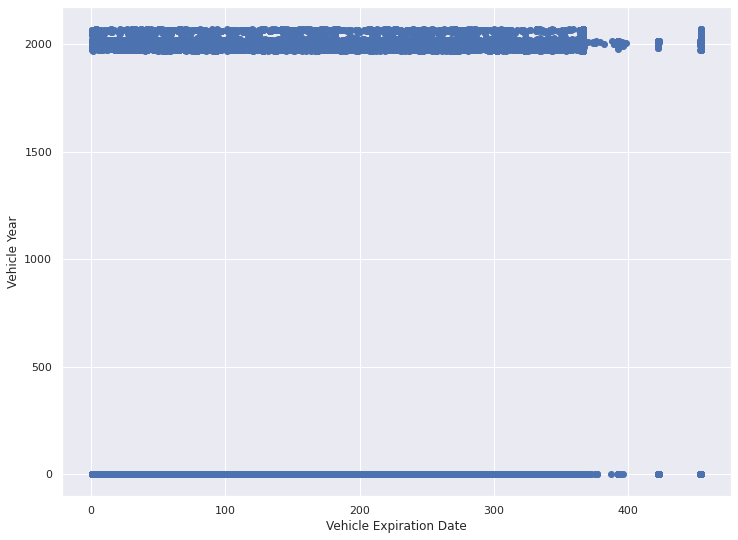

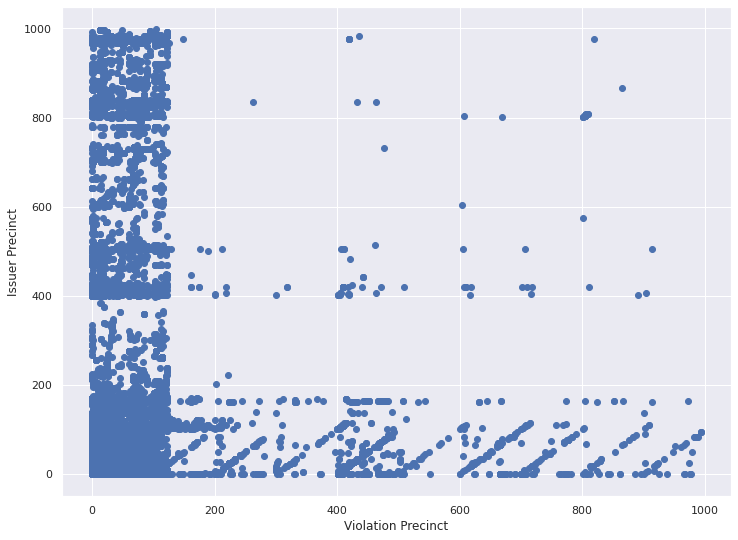

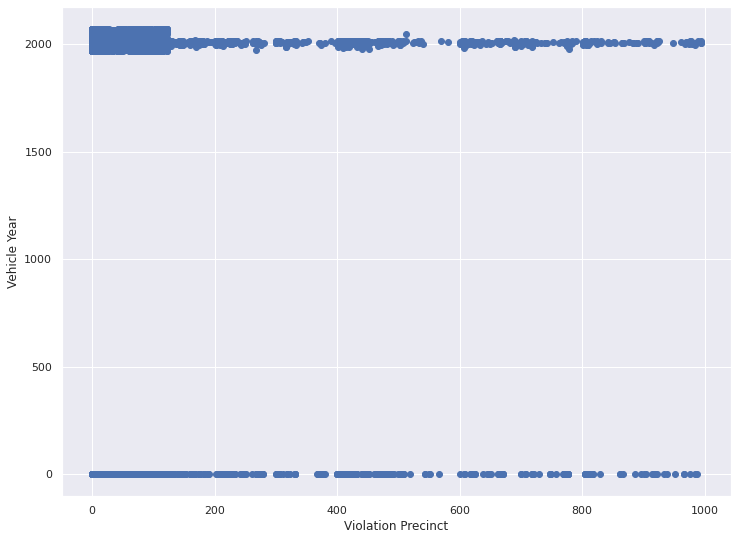

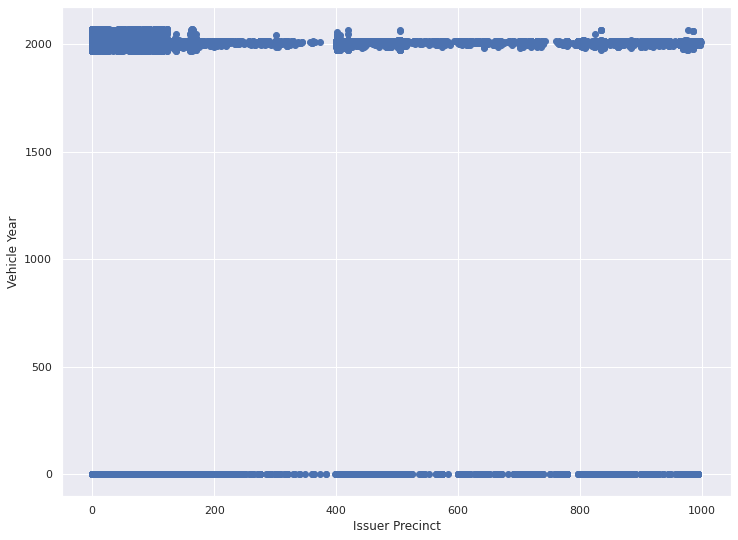

In [13]:
# visualize_cols(clean_data_15)

# Standardization

In [ ]:
scaler = StandardScaler()
clean_data_15 = scaler.fit_transform(clean_data_15)

### Verifying zero mean and standard deviation of all features

In [24]:
# for col in range(clean_data_15.shape[1]):
#     print(np.std(clean_data_15[:,col]))
#     print(np.mean(clean_data_15[:,col]))
#     print("\n\n")

0.9999999999999997
-2.592151895163557e-16



1.0000000000000018
1.9038251459093257e-16



1.0000000000000004
2.3537886740232107e-17



0.9999999999999998
4.3802611316178354e-18





### PCA

In [ ]:
pca = PCA()
pca.fit(clean_data_15).compute()

 - This is the percentage of the variance accounted for by each indivaidual principal component
 - sum of all these values is equal to one i.e. 100%

In [13]:
pca.explained_variance_ratio_

array([0.43865531, 0.31654858, 0.14570041, 0.0990957 ])

In [14]:
pca.explained_variance_

array([1.75462139, 1.26619441, 0.58280169, 0.39638285])

Text(0, 0.5, 'Cumulative Explained Variance')

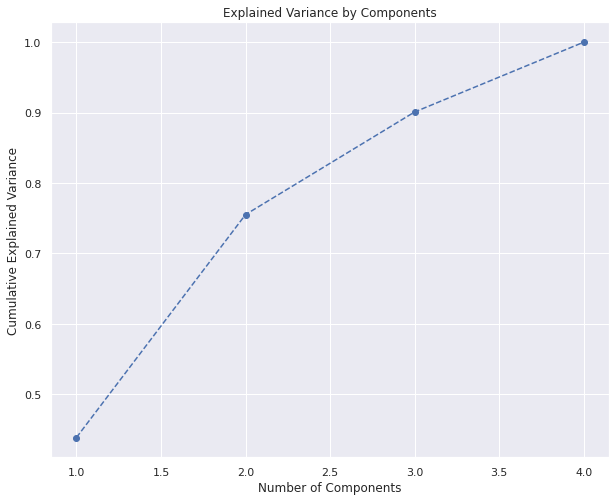

In [28]:
plt.figure(figsize=(10,8))
plt.plot(range(1,5),pca.explained_variance_ratio_.cumsum(),marker='o',linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

 - rule of thumb is to preserve around 80 % of the variance. 
 - No option but to keep 3 components

performing PCA with the chosen number of components

In [10]:
pca = PCA(n_components = 3)

# Fit the model to data with the selected number of components = 3
pca.fit(clean_data_15)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [11]:
# calculating the resulting components scores for the elements in our data set
scores_pca = pca.transform(clean_data_15)
scores_pca

array([[-0.02062719, -1.87768426, -1.17747269],
       [-1.55677288,  1.70463222, -0.30781912],
       [ 1.12521171, -0.5790503 , -0.17051415],
       ...,
       [-0.74073828, -0.66007101,  0.37236569],
       [ 1.37048132,  0.41901764,  0.78677972],
       [-0.52500395, -1.20942021, -0.28991378]])

In [12]:
del clean_data_15

In [8]:
scores_pca[0:2000].shape

(2000, 3)

In [9]:
# incorporating the newly obtained PCA scores in the K-means algorithm
# determining the Within Cluster Sum of Squares(WCSS) for each solution by Elbow Method

# We are taking only the first 2000 points as running this through the entre dataset is very expensive

# K means clustering with PCA
# Fitting K Means using transformed data from the PCA
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++',random_state = 42)
    kmeans_pca.fit(scores_pca[0:2000])
    wcss.append(kmeans_pca.inertia_)

determining the number of clusters 
kink or elbow in the WCSS graph is at the 3.125 ~= 3 clusters mark

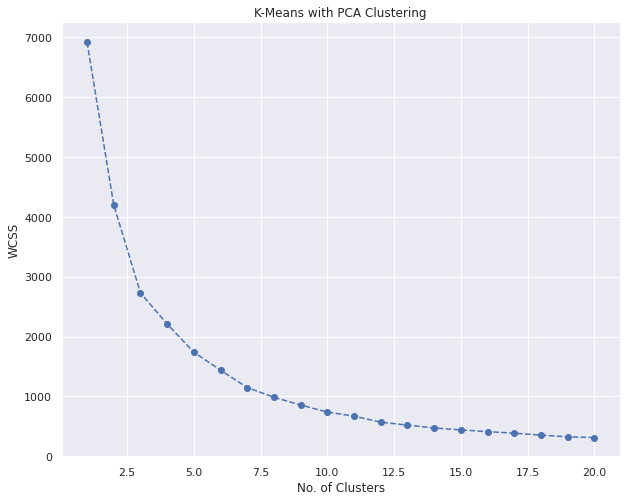

In [10]:
# plotting the WCSS against the number of components on a graph
plt.figure(figsize=(10,8))
plt.plot(range(1,21), wcss, marker='o', linestyle='--')
plt.xlabel('No. of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means with PCA Clustering')
plt.show()

## Implementing KMeans after PCA and using the no. of reqd clusters

In [13]:
kmeans_pca = KMeans(n_clusters=3,init='k-means++',random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [14]:
clean_data_15 = pd.read_hdf("./clean_data_15.h5")
clean_data_15 = clean_data_15.dropna()

In [15]:
kmeans_pca_15 = pd.concat([clean_data_15.reset_index(drop=True),pd.DataFrame(scores_pca)],axis=1)

In [16]:
kmeans_pca_15.columns.values[-3:] = ['Component 1','Component 2','Component 3']

In [17]:
# the last column we add contains the pca k-means clutering labels
kmeans_pca_15['Segment K-means PCA'] = kmeans_pca.labels_

In [18]:
kmeans_pca_15.head()

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year,Component 1,Component 2,Component 3,Segment K-means PCA
0,11,7,7,2005.0,-0.020627,-1.877684,-1.177473,1
1,454,25,25,0.0,-1.556773,1.704632,-0.307819,2
2,145,72,72,2010.0,1.125212,-0.579050,-0.170514,0
3,11,102,102,2015.0,2.317105,-0.705638,-0.702545,0
4,454,28,28,0.0,-1.483025,1.741915,-0.293054,2


In [19]:
kmeans_pca_15['Segment'] = kmeans_pca_15['Segment K-means PCA'].map({0:'first',
                                                                     1:'second',
                                                                     2:'third'})

In [20]:
kmeans_pca_15=kmeans_pca_15.drop(columns='Segment K-means PCA')

In [21]:
kmeans_pca_15

,Vehicle Expiration Date,Violation Precinct,Issuer Precinct,Vehicle Year,Component 1,Component 2,Component 3,Segment
0,11,7,7,2005.0,-0.020627,-1.877684,-1.177473,second
1,454,25,25,0.0,-1.556773,1.704632,-0.307819,third
2,145,72,72,2010.0,1.125212,-0.579050,-0.170514,first
3,11,102,102,2015.0,2.317105,-0.705638,-0.702545,first
4,454,28,28,0.0,-1.483025,1.741915,-0.293054,third
...,...,...,...,...,...,...,...,...
11809225,331,81,81,0.0,0.235863,1.946103,-0.659476,third
11809226,191,14,14,2013.0,-0.455437,-1.132466,-0.219169,second
11809227,304,18,18,2007.0,-0.740738,-0.660071,0.372366,second
11809228,304,104,104,1995.0,1.370481,0.419018,0.786780,first


In [22]:
del clean_data_15,kmeans_pca,PCA,pca,reqd_cols,scores_pca

In [23]:
kmeans_pca_15.dtypes

Vehicle Expiration Date      int64
Violation Precinct           int64
Issuer Precinct              int64
Vehicle Year               float64
Component 1                float64
Component 2                float64
Component 3                float64
Segment                     object
dtype: object

In [25]:
kmeans_pca_15.to_hdf('kmeans_pca_15.h5', key='df', mode='w')

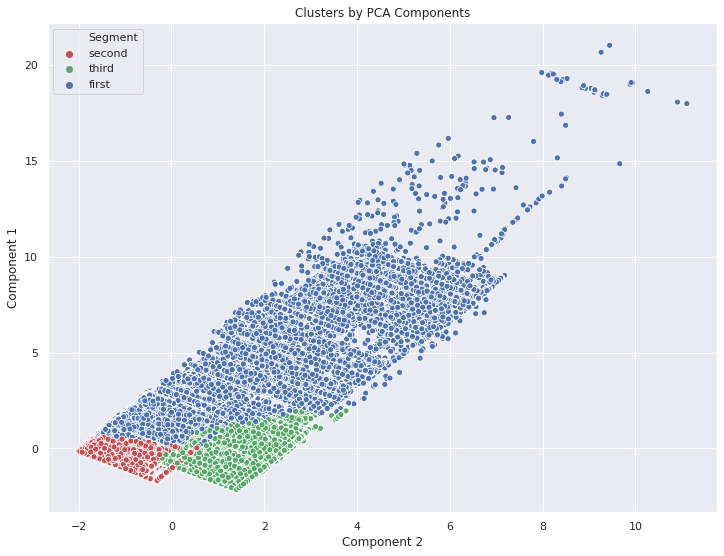

In [26]:
# Visualization
x_axis = kmeans_pca_15['Component 2']
y_axis = kmeans_pca_15['Component 1']
plt.figure(figsize=(12,9))
sns.scatterplot(x_axis,y_axis,hue=kmeans_pca_15['Segment'],palette=['r','g','b'])
plt.title('Clusters by PCA Components')
plt.show()